In [2]:
import numpy as np

import pandas as pd

import pickle

import matplotlib
matplotlib.rcParams.update({'font.size': 22})
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm

from skimage.external.tifffile import imread, imsave, TiffFile
from skimage.measure import regionprops, find_contours
from skimage.draw import circle
from skimage.morphology import disk, erosion, dilation
from skimage.filters import threshold_mean

from scipy import ndimage as ndi
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

from smtools.misc import straight_line

import warnings
warnings.filterwarnings("ignore")
import os


def correct_drop_intensity(Image):
    # NOTE: this uses the make_segments definition

    r_intensity = []
    r_value = []
    c_intensity = []
    c_value = []

    segmented = make_segments(Image)
    labels, _ = ndi.label(segmented)
    for segment in regionprops(labels):
        tmp_r = []
        tmp_c = []
        for r,c in segment.coords:
            tmp_r.append(Image[r,c])
            tmp_c.append(Image[r,c])

        r_intensity.append(np.mean(tmp_r))  
        c_intensity.append(np.mean(tmp_c)) 
        r_value.append(segment.centroid[0])
        c_value.append(segment.centroid[1])

    popt_r,_ = curve_fit(straight_line, r_value, r_intensity)
    popt_c,_ = curve_fit(straight_line, c_value, c_intensity)

    # Now we go back and scale the original.
    thresh = threshold_mean(Image)
    scaled_im = np.zeros_like(Image)
    for r in range(np.shape(Image)[0]):
        for c in range(np.shape(Image)[1]):
            if Image[r,c] > thresh:
                scaled_im[r,c] = Image[r,c] + abs(r*popt_r[0]) + abs(c*popt_c[0])
            else:
                scaled_im[r,c] = Image[r,c]
            
    return scaled_im


def make_segments(Image, threshold = .2, 
                  thresh_ecc = 1, thresh_area = 50):
    """
    :param Image: 2-dimensional image array.
    :param threshold: signal floor relative to maximum signal 
    :param thresh_ecc: maximum allowable eccentricity for detected segments 
    :param thresh_area: minimum allowable area for detected segments
    
    :return: 2-dimensional boolean array.
    """
    bool_diff = (Image/np.amax(Image) > threshold)
    labels, _ = ndi.label(bool_diff)
    filtered = np.zeros_like(Image)
    for j in regionprops(labels):
        if j.eccentricity<thresh_ecc and j.area>thresh_area:
            for y,x in j.coords:
                filtered[y,x] = 1
    return filtered

def power_law(x,a,k,b):
    return (a*(x**k))+b

def biexponential(x,k1,k2,a1,a2):
    return a1*np.exp(k1*x) + a2*np.exp(k2*x)

### FRAP analysis
---

In our FRAP experiments, the intensity of fluorescent HP1$\alpha$ decays differentially depending on whether or not that HP1$\alpha$ is inside or outside of a droplet and depending on where it is located in the field of view. The former, we attribute to the novel physio-chemical environment of the condensates and the latter to non-homogenous illumination of the sample. With this notebook, we first illustrate the problem, then we demonstate how we perform the analysis of our data given these circumstances.


In [3]:
im_paths = ["shortvidcropped/"+i for i in os.listdir("shortvidcropped")]
im_paths.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
im_list = [imread(i) for i in im_paths if i.endswith(".tiff")]
im_stack = np.dstack(im_list)

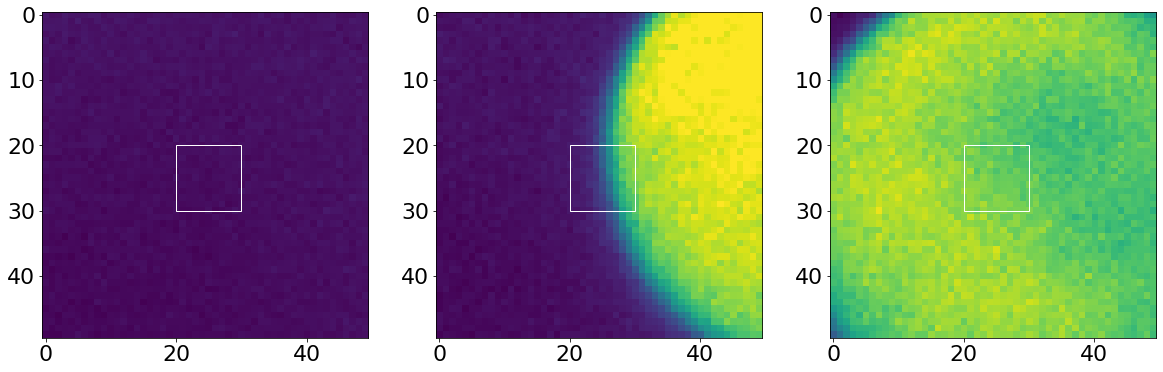

In [4]:
fig = plt.figure(figsize=(20,6))

ax1 = fig.add_subplot(131)
basex = 430
basey = 170
ax1.imshow(im_stack[basex - 20 :basex +20 +10,basey - 20 :basey +20 +10,0],
           vmax = np.amax([im_stack[:,:,0]])/1.5)
rect = Rectangle((20,20),10,10,linewidth=1,edgecolor='white',facecolor='none')
ax1.add_patch(rect)

ax2 = fig.add_subplot(132)
basex = 270
basey = 750
ax2.imshow(im_stack[basex - 20 :basex +20 +10,basey - 20 :basey +20 +10,0],
           vmax = np.amax([im_stack[:,:,0]])/1.5)
rect = Rectangle((20,20),10,10,linewidth=1,edgecolor='white',facecolor='none')
ax2.add_patch(rect)

ax3 = fig.add_subplot(133)
basex = 430
basey = 240
ax3.imshow(im_stack[basex - 20 :basex +20 +10,basey - 20 :basey +20 +10,0],
           vmax = np.amax([im_stack[:,:,0]])/1.5)
rect = Rectangle((20,20),10,10,linewidth=1,edgecolor='white',facecolor='none')
ax3.add_patch(rect)

plt.show()

To demonstrate the differential decay rates depending on HP1$\alpha$ location, we picked three 100x100 pixel regions (not in area of the laser strike) of the video and track the intensity over the movie, shown above.

The time-dependent decay of intensity at every pixel is fit to a bi-exponential decay equation:

\begin{align}
y(t) = a e^{-k_1 t}+ b e^{-k_2 t}
\end{align}

We then normalize the intensity by dividing through by $a+b$.

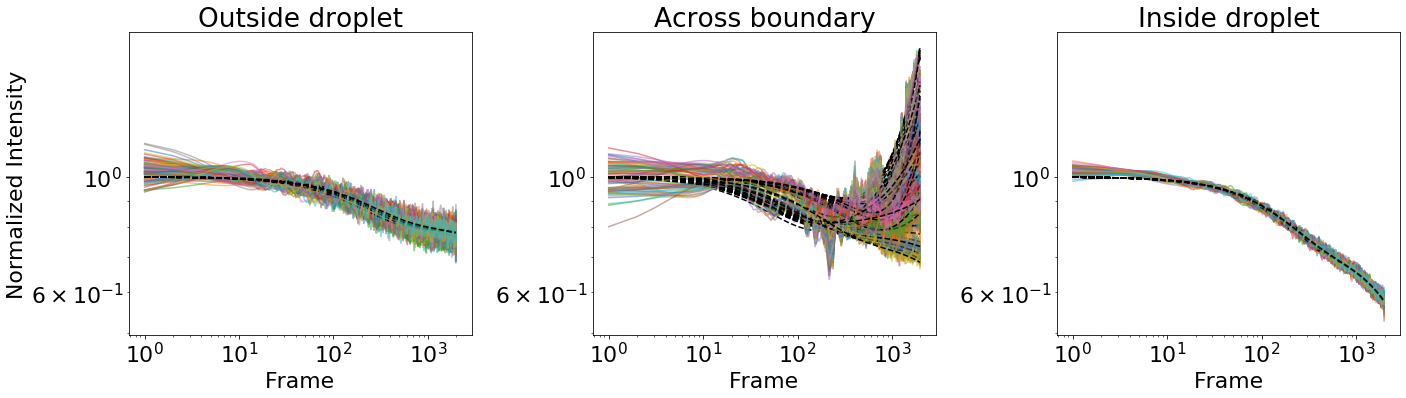

                 Slow rate, k1  Fast rate, k2
Outside droplet      -0.000024      -0.004493
Across boundary       0.000243      -0.007602
Inside droplet       -0.000131      -0.005903


In [5]:
fig = plt.figure(figsize=(20,6))

ax1 = fig.add_subplot(131)
ax1.set_title("Outside droplet")
ax1.set_xlabel("Frame")
ax1.set_ylabel("Normalized Intensity")
k1_vals = []
k2_vals = []
for row in range(10):
    for col in range(10):
        xj=430
        yj=170
        y = im_stack[row+xj,col+yj,:]
        filt_y = savgol_filter(y, 25, 3)
        x = np.array([i+1 for i in range(len(filt_y))])    
        try:
            p,e = curve_fit(biexponential,x,filt_y, p0=[-.01,-.01, .5, .5])
            k1_vals.append(max(p[0],p[1]))
            k2_vals.append(min(p[0],p[1]))
            a1 = p[2]/(p[2]+p[3])
            a2 = p[3]/(p[2]+p[3])
            params = np.array([p[0],p[1],a1,a2])
            newy = [i/(p[2]+p[3]) for i in filt_y]
            
            ax1.loglog(x,newy, alpha = .5)
            ax1.loglog(x,biexponential(x,*params), "k--")
        except RuntimeError:
            pass
k1_1 = np.mean(k1_vals)
k2_1 = np.mean(k2_vals)


ax2 = fig.add_subplot(132,sharey = ax1)
ax2.set_title("Across boundary")
ax2.set_xlabel("Frame")
k1_vals = []
k2_vals = []
for row in range(10):
    for col in range(10):
        xj=270
        yj=750
        y = im_stack[row+xj,col+yj,:]
        filt_y = savgol_filter(y, 25, 3)
        x = np.array([i+1 for i in range(len(filt_y))])
        try:
            p,e = curve_fit(biexponential,x,filt_y, p0=[-.01,-.01, .5, .5])
            k1_vals.append(max(p[0],p[1]))
            k2_vals.append(min(p[0],p[1]))
            a1 = p[2]/(p[2]+p[3])
            a2 = p[3]/(p[2]+p[3])
            params = np.array([p[0],p[1],a1,a2])
            newy = [i/(p[2]+p[3]) for i in filt_y]
            
            ax2.loglog(x,newy, alpha = .5)
            ax2.loglog(x,biexponential(x,*params), "k--")
        except RuntimeError:
            pass
k1_2 = np.mean(k1_vals)
k2_2 = np.mean(k2_vals)
      
ax3 = fig.add_subplot(133, sharey = ax1)
ax3.set_title("Inside droplet")
ax3.set_xlabel("Frame")
k1_vals = []
k2_vals = [] 
for row in range(10):
    for col in range(10):
        xj=430
        yj=240
        y = im_stack[row+xj,col+yj,:]
        filt_y = savgol_filter(y, 25, 3)
        x = np.array([i+1 for i in range(len(filt_y))])
        try:
            p,e = curve_fit(biexponential,x,filt_y, p0=[-.01,-.01, .5, .5])
            k1_vals.append(max(p[0],p[1]))
            k2_vals.append(min(p[0],p[1]))
            a1 = p[2]/(p[2]+p[3])
            a2 = p[3]/(p[2]+p[3])
            params = np.array([p[0],p[1],a1,a2])
            newy = [i/(p[2]+p[3]) for i in filt_y]
            
            ax3.loglog(x,newy, alpha = .5)
            ax3.loglog(x,biexponential(x,*params), "k--")
        except RuntimeError:
            pass
k1_3 = np.mean(k1_vals)
k2_3 = np.mean(k2_vals)

plt.tight_layout()
plt.show()


df = pd.DataFrame({'Slow rate, k1' : [k1_1, k1_2, k1_3],
                   'Fast rate, k2' : [k2_1, k2_2, k2_3]})
df.index = [ 'Outside droplet','Across boundary','Inside droplet']
print(df)



There are at least three important things to note for the analysis forthcoming. First, and most obvious, intensity values near the boundary of droplets is problematic. This results from random motion and oscillations of droplets during the timecourse of imaging. We omit pixels near the boundary from our analysis downstream because of this fact. Second, both inside and outside of the droplet, the decay rate does not vary wildly from pixel to pixel. However, third, both the slow and fast decay rates are faster inside of the droplets. **NOTE:** The regions inside and outside of condensates here are local to one another in the image, this is because we also find that rates vary with position in the image. 

There are a number of reasons as to why fluorescent HP1$\alpha$ might decay faster in condensates, but we do not investigate the origin of this behavor. Rather, we use only the signal from fluorescent HP1$\alpha$ in condensates to correct for recovery in our FRAP analysis.

Next to demonstrate the spatial effects on droplet intensity, we first segment the image and determine which droplets  are more or less stationary during the experiment and that do not undergo a fusion event, as both would have effects on the fluorescent signal that we would rather not control for. Then we remove pixels near the edge of droplets from our segmented regions to avoid them in the analysis as well. Also, we omit the droplet that is purposely bleached in this experiment.

In [7]:
start_im = im_stack[:,:,0]
corrected_start_im = correct_drop_intensity(start_im)
segmented_start_im = make_segments(corrected_start_im)
labels_start_im, _ = ndi.label(segmented_start_im)
start_coordinate_list = [n.coords for n in regionprops(labels_start_im) if n.area>25]

end_im = im_stack[:,:,-1]
corrected_end_im = correct_drop_intensity(end_im)
segmented_end_im = make_segments(corrected_end_im)
labels_end_im, _ = ndi.label(segmented_end_im)
# remove the FRAP droplet from this segmented image
# r-position of the droplet determined by guess +/- 10 pixels
x, y = 240, 310
r_FRAP = np.sqrt((x**2) + (y**2))
end_coordinate_list = [] 
for n in regionprops(labels_end_im):
    r_value = np.sqrt((n.centroid[0]**2) + (n.centroid[1]**2))
    if (n.area>25 and abs(r_FRAP-r_value)>10):
        end_coordinate_list.append(n.coords)
                       
intersection_coordinate_list = []
for start_segment in start_coordinate_list:
    start_set = set([tuple(x) for x in start_segment])
    for end_segment in end_coordinate_list:
        end_set = set([tuple(x) for x in end_segment])
        if (len(start_set & end_set) / len(start_set) >= 0.9 and
            len(start_set & end_set) / len(end_set) >= 0.9):
            intersection_coordinate_list.append(start_segment)
            
intersection_image = np.zeros_like(start_im)
for each in intersection_coordinate_list:
    for x,y in each:
        intersection_image[x,y] = 1 


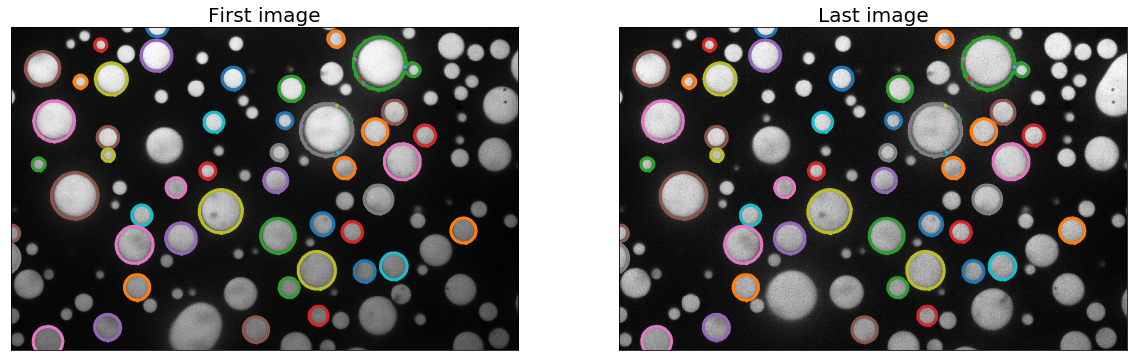

In [8]:
start_im = im_stack[:,:,0]
end_im = im_stack[:,:,-1]   
    
fig = plt.figure(figsize=(20,16))

ax1 = fig.add_subplot(121)
ax1.set_title("First image", fontsize = 20)
ax1.imshow(start_im, cmap = 'Greys_r' ,vmax = np.amax(start_im))
contours = find_contours(intersection_image, .1)
for n, contour in enumerate(contours):
    ax1.plot(contour[:, 1], contour[:, 0], linewidth=3)

ax2 = fig.add_subplot(122)
ax2.set_title("Last image", fontsize = 20)
ax2.imshow(end_im, cmap = 'Greys_r' ,vmax = np.amax(end_im))
for n, contour in enumerate(contours):
    ax2.plot(contour[:, 1], contour[:, 0], linewidth=3)
    
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

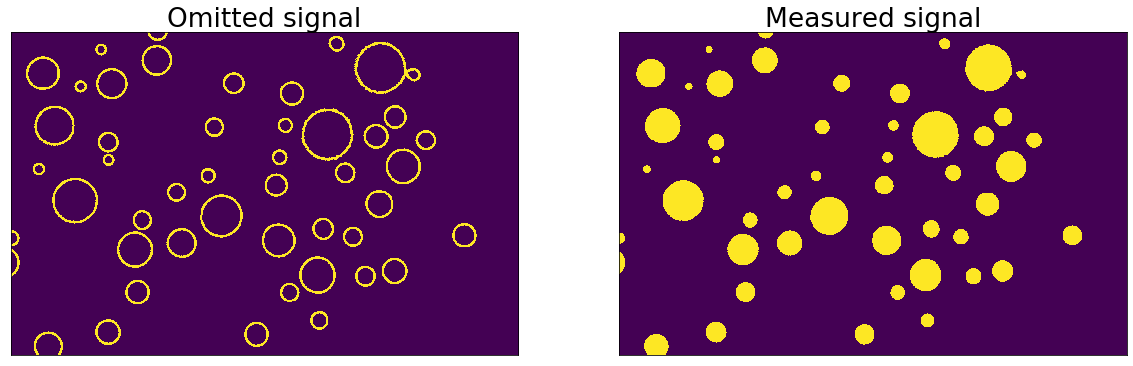

In [9]:
eroded_in = erosion(intersection_image, disk(5))

fig = plt.figure(figsize=(20,16))

ax1 = fig.add_subplot(121)
ax1.imshow(np.logical_xor(intersection_image,eroded_in))
ax1.set_title("Omitted signal")
ax2 = fig.add_subplot(122)
ax2.imshow(eroded_in)
ax2.set_title("Measured signal")


ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

Next we collect the average intensity as a function of time for each droplet, and fit the fluorescence decay to the bi-exponential function. Then we visualize the result two ways. First by coloring the decay curves by either their row or column position in the image. And second by coloring a 2D image array such that the positively segmented regions are colored proportionately to the rate parameters from determined from the fit for that segment. 

In [10]:
steady_labels,_ = ndi.label(eroded_in)
intensity_vector = []
total = len(regionprops(steady_labels))
for droplet in regionprops(steady_labels):
    avg_signal = []
    for frame in range(im_stack.shape[2]):
        ##-- only taking one out of every 5 frames.
        ##-- check later if using time vector instead of frames.
        if frame%5==0: 
            current_im = im_stack[:,:,frame]
            avg_signal.append(np.mean([current_im[r,c] for r,c in droplet.coords]))
    intensity_vector.append((avg_signal,droplet.coords,droplet.centroid))

    


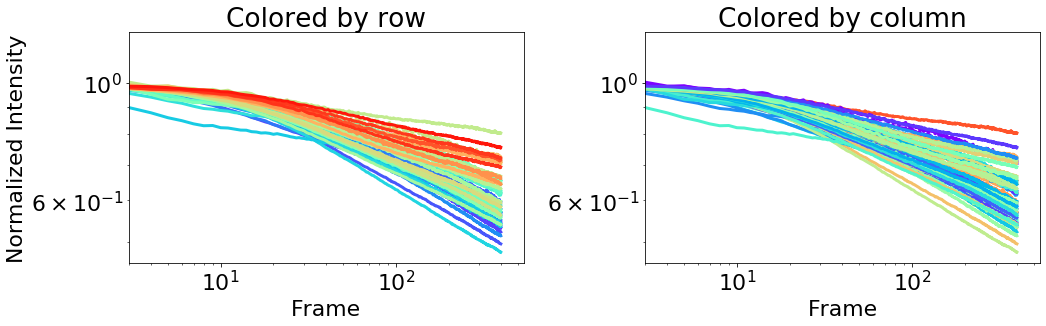

In [11]:
r_pos = [center[0]/im_stack[:,:,0].shape[0] for signal,coords,center in intensity_vector]
c_pos = [center[1]/im_stack[:,:,0].shape[1] for signal,coords,center in intensity_vector]
r_colors = cm.rainbow(np.array(r_pos))
c_colors = cm.rainbow(np.array(c_pos))
count = 0
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.set_title("Colored by row")
ax2 = fig.add_subplot(122)
ax2.set_title("Colored by column")
x = np.array([i+1 for i in range(len(intensity_vector[0][0]))])    
for signal,coords,center in intensity_vector:    
    try:
        p,e = curve_fit(biexponential,x,signal, p0=[-.01,-.01, .5, .5])
        a1 = p[2]/(p[2]+p[3])
        a2 = p[3]/(p[2]+p[3])
        params = np.array([p[0],p[1],a1,a2])
        newy = [i/(p[2]+p[3]) for i in signal]
        ax1.loglog(x,newy, linewidth = 3, color = r_colors[count])
        ax2.loglog(x,newy, linewidth = 3, color = c_colors[count])
    except RuntimeError:
        pass
    count+=1
ax1.set_xlim(3)
ax2.set_xlim(3)
ax1.set_ylabel("Normalized Intensity")
ax1.set_xlabel("Frame")
ax2.set_xlabel("Frame")
plt.tight_layout()
plt.show()

In [12]:
k1_image = np.zeros_like(start_im).astype(float)
k2_image = np.zeros_like(start_im).astype(float)
for signal,coords,center in intensity_vector:
    x = np.array([i for i in range(len(signal))])    
    try:
        p,e = curve_fit(biexponential,x,signal, p0=[-.01,-.01, .5, .5])
        for r,c in coords:
            k1_image[r,c] = max(p[0],p[1])
            k2_image[r,c] = min(p[0],p[1])
    except RuntimeError:
        pass
k1_image = np.ma.masked_where(k1_image==0, k1_image)
k2_image = np.ma.masked_where(k2_image==0, k2_image)

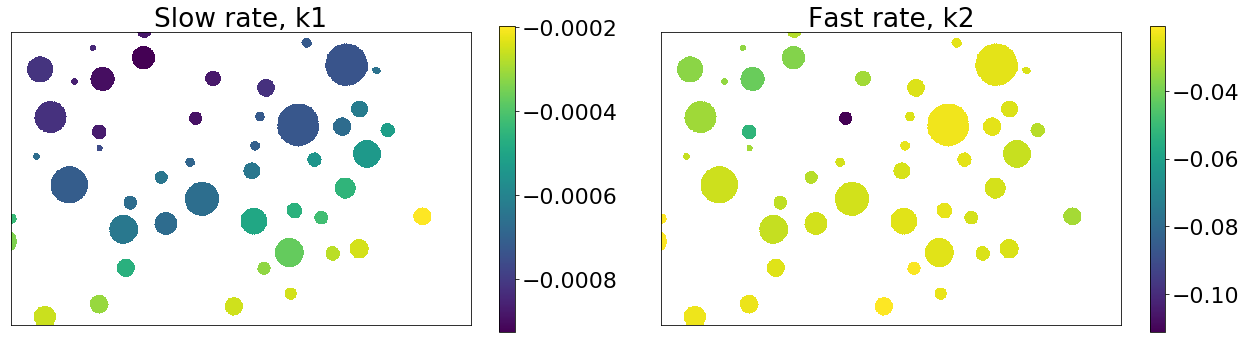

In [13]:
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(k1_image)
ax1.set_title("Slow rate, k1")
ax2 = fig.add_subplot(122)
im2 = ax2.imshow(k2_image)
ax2.set_title("Fast rate, k2")


ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.colorbar(im1, ax = ax1)
plt.colorbar(im2, ax = ax2)
plt.tight_layout()
plt.show()

From the above plots its clear that there is a gradient of rates across the field of view. This is also true in the background signal (not shown). We expect this is the result of non-uniform illumination. We  also look to the population factors, $a$ and $b$, to see whether or not they are also subject to this same phenomenon, but do not find the relative proportion of fast and slow decay to be a spatially dependent (not shown).


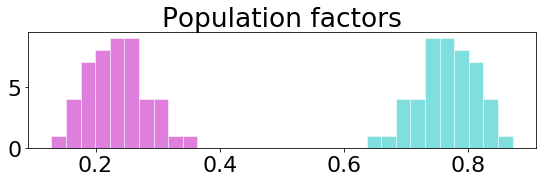

In [14]:
#a1_image = np.zeros_like(start_im).astype(float)
#a2_image = np.zeros_like(start_im).astype(float)
a1_hist = []
a2_hist = []
for signal,coords,center in intensity_vector:
    x = np.array([i for i in range(len(signal))])    
    try:
        p,e = curve_fit(biexponential,x,signal, p0=[-.01,-.01, .5, .5])
        a1 = max(p[2],p[3])
        a2 = min(p[2],p[3])
        a1_hist.append(a1/(a1+a2))
        a2_hist.append(a2/(a1+a2))
        #for r,c in coords:
        #    a1_image[r,c] = a1/(a1+a2)
        #    a2_image[r,c] = a2/(a1+a2)
    except RuntimeError:
        pass
#a1_image = np.ma.masked_where(a1_image==0, a1_image)
#a2_image = np.ma.masked_where(a2_image==0, a2_image)
#fig = plt.figure(figsize=(18,5))
#ax1 = fig.add_subplot(121)
#im1 = ax1.imshow(a1_image)
#ax1.set_title("Larger population")
#ax2 = fig.add_subplot(122)
#im2 = ax2.imshow(a2_image)
#ax2.set_title("Smaller population")
#ax1.set_xticks([])
#ax1.set_yticks([])
#ax2.set_xticks([])
#ax2.set_yticks([])
#plt.colorbar(im1, ax = ax1)
#plt.colorbar(im2, ax = ax2)
#plt.tight_layout()
#plt.show()
        
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(111)
ax1.set_title("Population factors")
ax1.hist(a1_hist, fc = "c", 
         ec = "white", alpha = 0.5)
ax1.hist(a2_hist, fc = "m", 
         ec = "white", alpha = 0.5)
plt.tight_layout()
plt.show()

Given the above, we decided to scale the decay rates in the following way to correct for spatial variation:

\begin{align}
\bar y(t) = \langle a \rangle e^{-k_1(x,y) t}+ \langle b \rangle e^{-k_2(x,y) t} \\
k_1(x,y) = k_1^0 + x \alpha_1 + y \beta_1 \\
k_2(x,y) = k_2^0 + x \alpha_2 + y \beta_2
\end{align}

where $\alpha$ and $\beta$ and $k_1^0$ and $k_2^0$ are the slopes and intercepts from fitting a plane to the decay rate versus position in the image, $\langle a \rangle$ and $\langle b \rangle$ are the average population factors, and $\bar y(t)$ is the normalized intensity signal (see below). 
**Note:** we remove the aberant droplet at (190,410) as it is affected by the bleach strike.

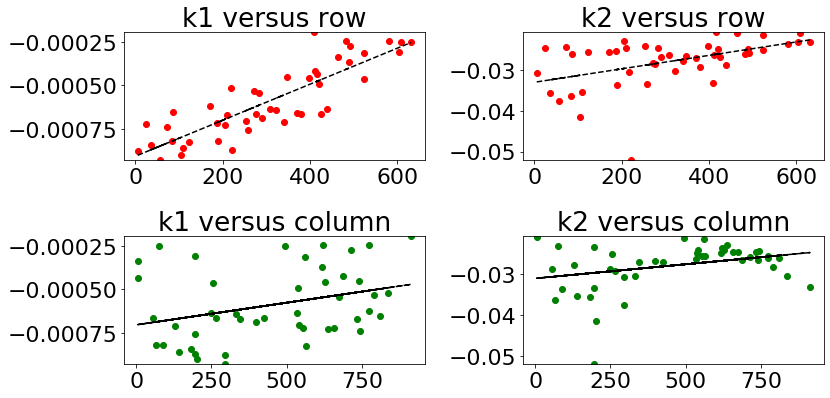

In [15]:
k1 = []
k2 = []
r = []
c = []
frames = np.array([i+1 for i in range(len(intensity_vector[0][0]))])    
for signal,coords,center in intensity_vector:
    x, y = 190, 410
    r_FRAP = np.sqrt((x**2) + (y**2))
    r_value = np.sqrt((center[0]**2) + (center[1]**2))
    if abs(r_FRAP-r_value)>10:
        try:
            p,e = curve_fit(biexponential,frames,signal, p0=[-.01,-.01, .5, .5])
            k1.append(max(p[0],p[1]))
            k2.append(min(p[0],p[1]))
            r.append(center[0])
            c.append(center[1])
        except RuntimeError:
            pass


fig = plt.figure(figsize=(12,6))
        
ax1 = fig.add_subplot(221)   
ax1.set_title("k1 versus row")
ax1.scatter(r, k1, c = "r")
p,e = curve_fit(straight_line,r,k1)
ax1.plot(r,straight_line(np.array(r),*p), "k--")
ax1.set_ylim(min(k1),max(k1))

ax2 = fig.add_subplot(223) 
ax2.set_title("k1 versus column")
ax2.scatter(c, k1, c = "g")
p,e = curve_fit(straight_line,c,k1)
ax2.plot(c,straight_line(np.array(c),*p), "k--")
ax2.set_ylim(min(k1),max(k1))

ax3 = fig.add_subplot(222)   
ax3.set_title("k2 versus row")
ax3.scatter(r, k2, c = "r")
p,e = curve_fit(straight_line,r,k2)
ax3.plot(r,straight_line(np.array(r),*p), "k--")
ax3.set_ylim(min(k2),max(k2))

ax4 = fig.add_subplot(224)
ax4.set_title("k2 versus column")
ax4.scatter(c, k2, c = "g")
p,e = curve_fit(straight_line,c,k2)
ax4.plot(c,straight_line(np.array(c),*p), "k--")
ax4.set_ylim(min(k2),max(k2))

plt.tight_layout()
plt.show()

In [16]:
from mpl_toolkits.mplot3d import Axes3D
def multiDline(data, a1, b1, k0):
    return data[:,0]*a1 +data[:,1]*b1 + k0

k1 = []
k2 = []
frames = np.array([i+1 for i in range(len(intensity_vector[0][0]))])    
for signal,coords,center in intensity_vector:
    x, y = 190, 410
    r_FRAP = np.sqrt((x**2) + (y**2))
    r_value = np.sqrt((center[0]**2) + (center[1]**2))
    if abs(r_FRAP-r_value)>10:
        try:
            p,e = curve_fit(biexponential,frames,signal, p0=[-.01,-.01, .5, .5])
            k1.append((center[0],center[1],max(p[0],p[1])))
            k2.append((center[0],center[1],min(p[0],p[1])))
        except RuntimeError:
            pass
k1 = np.array(k1)
k2 = np.array(k2)
p1,e = curve_fit(multiDline, k1[:,:2], k1[:,2])
p2,e = curve_fit(multiDline, k2[:,:2], k2[:,2])


df = pd.DataFrame({'k0' : [p1[2], p2[2]],
                   'alpha' : [p1[0], p2[0]],
                   'beta' : [p1[1], p2[1]],
                   'a' : [np.mean(a1_hist), ""],
                   'b' : ["", np.mean(a2_hist)],})
df.index = [ 'Slow rate, k1','Fast rate, k2']
print(df)

                     k0     alpha          beta         a         b
Slow rate, k1 -0.001026  0.000001  2.652060e-07  0.765326          
Fast rate, k2 -0.036279  0.000017  7.094658e-06            0.234674


### Analysis
---

The analysis proceeds as follows. We first use all of the non-FRAPed droplets to determine the average scaled rate parameters (shown above). Then we use the modified bi-exponential function to baseline correct the intensity signal from the FRAPed droplet. Now to determine how effective this process is, we are going to use the average corrected rate values to normalize the intensity versus time of all of the non-FRAPed droplets. The spread on this data gives us some a resonable measure of the error in this approach. Then finally, we plot the FRAP data against this error to determine how extensive the recovery is.

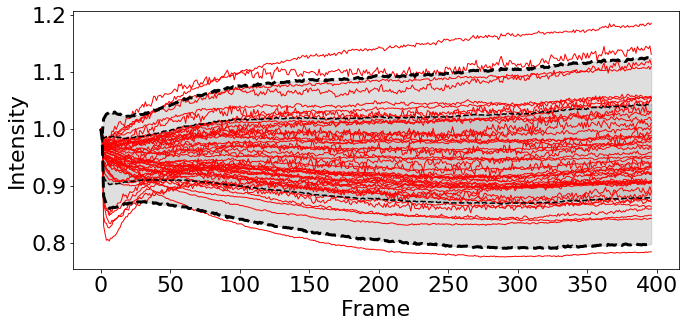

In [17]:
alpha_1, beta_1, k01 = p1
alpha_2, beta_2, k02 = p2
a = np.mean(a1_hist)
b = np.mean(a2_hist)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
x = np.array([i for i in range(len(intensity_vector[0][0]))])
data = []
for signal,coords,center in intensity_vector:  

    norm_signal = [i/signal[0] for i in signal]
    expected_k1 = k01 + alpha_1*center[0] + beta_1*center[1]
    expected_k2 = k02 + alpha_2*center[0] + beta_2*center[1]
    params = np.array([expected_k2,expected_k1,b,a])
    prediction = biexponential(x,*params)

    corrected_signal = [i/j for i,j in zip(norm_signal, prediction)]
    ax1.plot(x,corrected_signal, linewidth = 1, color = "r")
    data.append(corrected_signal)
    

upper = [np.mean(i)+np.std(i) for i in zip(*data)]
lower = [np.mean(i)-np.std(i) for i in zip(*data)]
ax1.plot(x,lower,"k--")
ax1.plot(x,upper,"k--")
ax1.fill_between(x,lower, upper, 
                 color = "grey", alpha = 0.25)
upper = [np.mean(i)+2*np.std(i) for i in zip(*data)]
lower = [np.mean(i)-2*np.std(i) for i in zip(*data)]
ax1.plot(x,lower,"k--", linewidth = 3)
ax1.plot(x,upper,"k--", linewidth = 3)
ax1.fill_between(x,lower, upper, 
                 color = "grey", alpha = 0.25)

ax1.set_ylabel("Intensity")
ax1.set_xlabel("Frame")
plt.tight_layout()
plt.show()

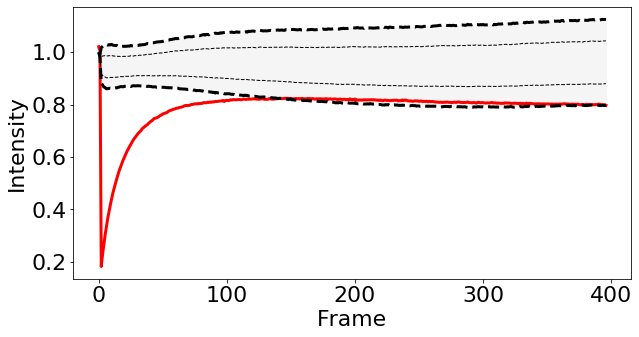

In [18]:
start_im = im_stack[:,:,0]
corrected_end_im = correct_drop_intensity(end_im)
segmented_end_im = make_segments(corrected_end_im)
labels_end_im, _ = ndi.label(segmented_end_im)
# select only the FRAP droplet from this segmented image
# r-position of the droplet determined by guess +/- 10 pixels
x, y = 240, 310
frap_coordinate_list = [] 
for n in regionprops(labels_end_im):
    r_value = np.sqrt((x-n.centroid[0])**2+(y-n.centroid[1])**2)
    if r_value<10:
        frap_coordinate_list.append(n.coords)
                       
frap_image = np.zeros_like(start_im)
for each in frap_coordinate_list:
    for x,y in each:
        frap_image[x,y] = 1 

eroded_in = erosion(frap_image, disk(5))
steady_labels,_ = ndi.label(eroded_in)
fig = plt.figure(figsize = (10,5))
for droplet in regionprops(steady_labels):
    avg_signal = []
    for frame in range(im_stack.shape[2]):
        ##-- only taking one out of every 5 frames.
        ##-- check later if using time vector instead of frames.
        if frame%5==0: 
            current_im = im_stack[:,:,frame]
            avg_signal.append(np.mean([current_im[r,c] for r,c in droplet.coords]))
            
    x = np.array([i for i in range(len(avg_signal))])
    norm_signal = [i/avg_signal[1] for i in avg_signal]
    expected_k1 = k01 + alpha_1*center[0] + beta_1*center[1]
    expected_k2 = k02 + alpha_2*center[0] + beta_2*center[1]
    params = np.array([expected_k2,expected_k1,b,a])
    prediction = biexponential(x,*params)

    corrected_signal = [i/j for i,j in zip(norm_signal, prediction)]
    plt.plot(x,corrected_signal, linewidth = 3, color = "r")

upper = [np.mean(i)+2*np.std(i) for i in zip(*data)]
lower = [np.mean(i)-2*np.std(i) for i in zip(*data)]
plt.fill_between(x,lower, upper, label = "2 sigma",
                 color = "whitesmoke")
plt.plot(x,lower,"k--", linewidth = 3)
plt.plot(x,upper,"k--", linewidth = 3)
upper = [np.mean(i)+np.std(i) for i in zip(*data)]
lower = [np.mean(i)-np.std(i) for i in zip(*data)]
plt.plot(x,lower,"k--", linewidth = 1)
plt.plot(x,upper,"k--", linewidth = 1)
plt.ylabel("Intensity")
plt.xlabel("Frame")
plt.show()


Finally, its worth noting that the correction we perform is not perfect. In fact, there is still residual spatial variation in the decay rates. And, critically for our interpretation, each of our laser strikes was performed in generally the same location within the focal plane. This means that we expect for our recovery curves to generally look the same due to systematic error.